<a href="https://colab.research.google.com/github/Armanskij/Projeto-Imoveis/blob/main/Mapeando_pre%C3%A7os_de_alug%C3%A9is_com_o_uso_da_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size: 28px;">Mapeando preços de alugéis com o uso da Random Forest</h1>



#Introdução


Esse projeto faz parte dos meus estudos sobre aprendizado de máquina, realizados durante o curso de Analista de Dados da EBAC.

No *briefing*, fui orientado a escolher uma problemática da vida real e utilizar o aprendizado de máquina para solucioná-la. Dentre os diversos tipos de problemas e dados, escolhi trabalhar com valores de aluguéis na cidade de São Paulo. Minha escolha foi um dataset contendo as principais características dos imóveis e seus preços. Optei por esse tema devido à simplicidade e qualidade dos dados, além de ser um assunto com o qual tenho certa familiaridade.

Um dos primeiros problemas encontrados ao procurar um imóvel para alugar é conseguir avaliar se o preço está de acordo com outros imóveis com características semelhantes. São muitas variáveis a serem consideradas para saber se o imóvel está acima ou abaixo do preço. Para isso, vamos estudar e avaliar como o processo de aprendizado de máquina pode nos ajudar nessa escolha. Desde a etapa de coleta de dados até a visualização, veremos como se dá o processo de análise com o uso de aprendizado de máquina, seus pontos positivos e negativos, e, por fim, como ele pode nos auxiliar na escolha de imóveis.

In [ ]:
import os
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
warnings.filterwarnings('ignore') # suprimir mensagens de bibliotecas

# Coleta os Dados

In [ ]:
!pip install kaggle

In [ ]:
if not os.path.exists('dataset.zip'):
  !kaggle datasets download -d renatosn/sao-paulo-housing-prices
  !mv 'sao-paulo-housing-prices.zip' dataset.zip
  !unzip dataset.zip
  !ls

Dataset URL: https://www.kaggle.com/datasets/renatosn/sao-paulo-housing-prices
License(s): CC0-1.0
100% 211k/211k [00:00<00:00, 533kB/s]
100% 211k/211k [00:00<00:00, 532kB/s]
Archive:  dataset.zip
  inflating: data.csv                
data.csv  dataset.zip  sample_data


In [ ]:
df_v1 = pd.read_csv('dataset.zip')

Sobre o dataset:

* *Address* (str): Endereço do imóvel.
* *District* (str): Bairro do imóvel.
* *Area* (float): Metragem do imóvel (m²).
* *Bedrooms* (int): Número de quartos no imóvel.
* *Garage* (int): Vagas de garagem do imóvel.
* *Rent* (float): Valor do aluguel do imóvel
* *Type* (str): Tipo de imóvel (casa, apartamento).
* *Total* (float): Valor total do imóvel incluindo aluguel, impostos e outras taxas.


In [ ]:
df_v1.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


In [ ]:
df_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


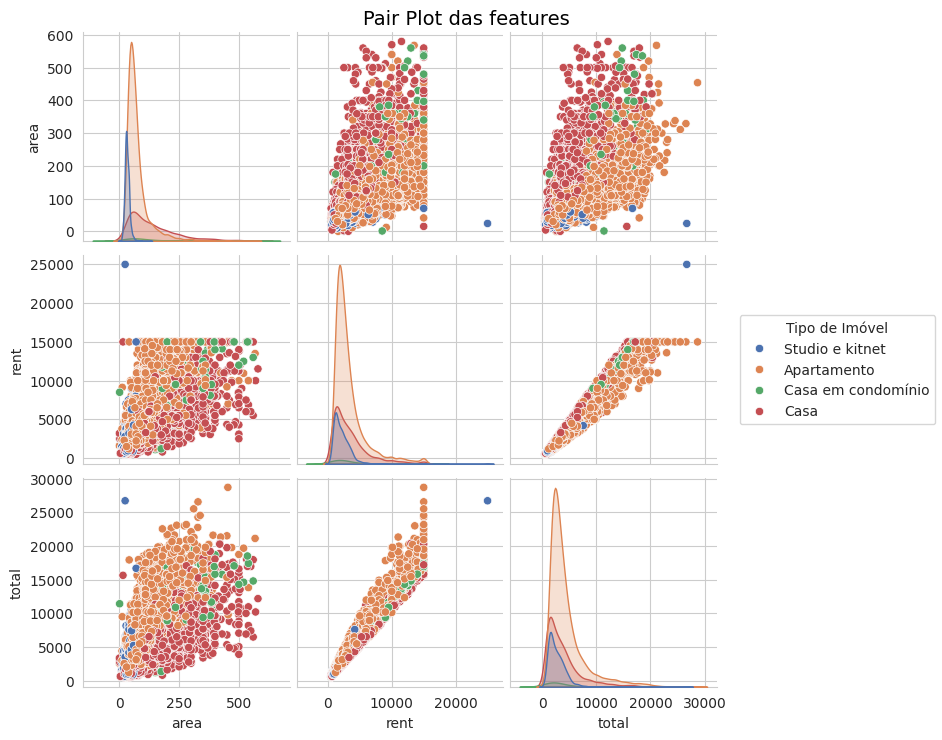

In [ ]:
# criando o pairplot
with sns.axes_style('whitegrid'):
  grafico = sns.pairplot(data=df_v1[['district','area','type','rent', 'total' ]], hue='type', palette='deep')

# organizando os elementos do gráfico
grafico.fig.suptitle('Pair Plot das features', fontsize=14)
grafico._legend.set_title("Tipo de Imóvel")
grafico._legend.set_frame_on(True)
plt.subplots_adjust(top=0.95)
plt.show()

In [ ]:
df_v2 = df_v1.drop('address', axis=1)

In [ ]:
df_v2.head()

,district,area,bedrooms,garage,type,rent,total
0,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Pinheiros,18,1,0,Apartamento,4000,4661
3,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Bela Vista,19,1,0,Studio e kitnet,4000,4654


In [ ]:
df_v2[['area','bedrooms','garage', 'rent','total']].describe().round(2)

,area,bedrooms,garage,rent,total
count,11657.00,11657.00,11657.00,11657.00,11657.00
mean,84.66,1.97,1.06,3250.81,4080.03
std,74.02,0.93,1.13,2650.71,3352.48
min,0.00,0.00,0.00,500.00,509.00
25%,40.00,1.00,0.00,1590.00,1996.00
50%,60.00,2.00,1.00,2415.00,3057.00
75%,96.00,3.00,2.00,3800.00,4774.00
max,580.00,6.00,6.00,25000.00,28700.00


# Modelagem dos dados

## District

A variável `district` é uma string que contém o nome do bairro onde o imóvel está localizado. Como são mais de 1000 bairros diferentes, faremos apenas uma visão geral dos que aparecem com mais frequência e trataremos esses dados para que o modelo de aprendizado de máquina possa processá-los. O estudo dessa variável com geolocalização e geoprocessamento pode agregar muito em diversas análises; porém, para o escopo deste projeto, não me aprofundarei nesse aspecto.

In [ ]:
# contando o número de bairros diferentes
bairros_unicos = df_v2['district'].nunique()
print(f'Ao total são {bairros_unicos} bairros diferentes')

Ao total são 1199 bairros diferentes


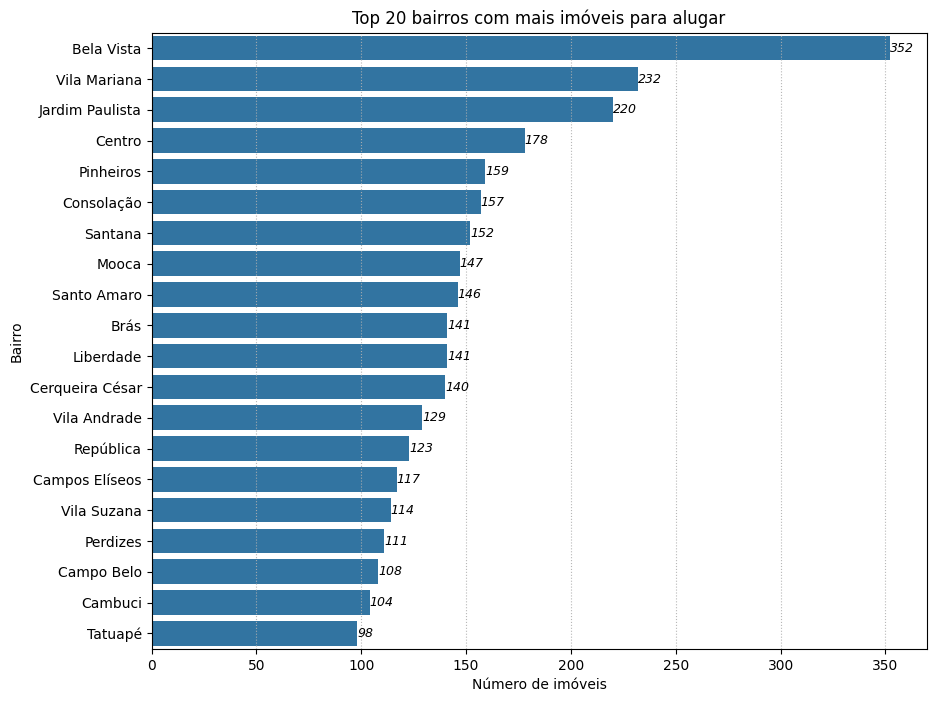

In [ ]:
# criando o gráfico com o top 20 número de imóveis
top_bairros = df_v2['district'].value_counts().head(20)

plt.figure(figsize=(10,8))
sns.barplot(x=top_bairros.values, y=top_bairros.index)
plt.title('Top 20 bairros com mais imóveis para alugar')
plt.xlabel('Número de imóveis')
plt.ylabel('Bairro')
plt.grid(axis='x', linestyle=':', alpha=0.9)
# inserindo o um numero na barra
for i in range(len(top_bairros)):
  plt.text(top_bairros.values[i], i, top_bairros.values[i],
           ha='left', va='center', fontsize=9,fontdict={'fontstyle': 'italic'})

Como na aplicação o modelo de aprendizagem utiliza apenas número iremos utilizar o método [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) para tranformar o nome do bairro em um código númerico, criando assim uma coluna chamada `disctrict_encoded`

In [ ]:
label_encoder = LabelEncoder()
df_v2['district_encoded'] = label_encoder.fit_transform(df_v2['district'])
df_v2.head()

,district,area,bedrooms,garage,type,rent,total,district_encoded
0,Belenzinho,21,1,0,Studio e kitnet,2400,2939,27
1,Vila Marieta,15,1,1,Studio e kitnet,1030,1345,984
2,Pinheiros,18,1,0,Apartamento,4000,4661,668
3,Vila Ré,56,2,2,Casa em condomínio,1750,1954,1097
4,Bela Vista,19,1,0,Studio e kitnet,4000,4654,26


In [ ]:
# a partir de agora não utilizaremos mais o nome do bairro
df_v2 = df_v2.drop(columns=['district'])

## Area


A variável `area` é um *float* que representa a área em metros quadrados dos imóveis, sendo uma das principais variáveis que estipulam o preço de um imóvel. Observaremos como é sua distribuição e a presença de *outliers*

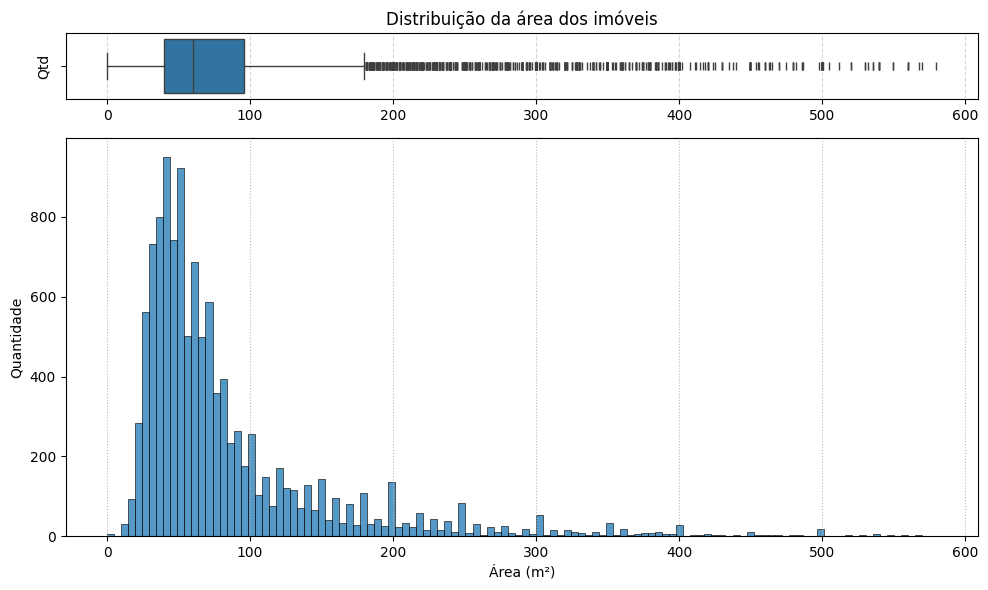

In [ ]:
# criando o gráfico para observar a distribuição da área
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[1,6]})

# boxplot das áreas
sns.boxplot(x=df_v2['area'], ax=axes[0], linewidth=1, flierprops={'marker':'|'})
axes[0].set_title('Distribuição da área dos imóveis')
axes[0].grid(axis='x', linestyle='--', alpha=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Qtd')


# histograma com a distribuição das áreas
sns.histplot(df_v2['area'], ax=axes[1])
axes[1].set_xlabel('Área (m²)')
axes[1].set_ylabel('Quantidade')
axes[1].grid(axis='x', linestyle=':', alpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
df_v2['area'].describe().round(2)


count    11657.00
mean        84.66
std         74.02
min          0.00
25%         40.00
50%         60.00
75%         96.00
max        580.00
Name: area, dtype: float64

Observando que existe uma grande presença de *outliers* escolhemos tratá-los usando o método de  [Amplitude Interquatil (IQR)](https://pt.wikipedia.org/wiki/Amplitude_interquartil), onde através de uma medida de dispersão estatística definiremos os limites superior e inferior dos nossos dados afim de limitar nossa amostra e melhorar a qualidade dos dados.

In [ ]:
# criando um função que aplica o método de amplitude interquartil
def methot_iqr (df, col_name):
  Q1 = df[col_name].quantile(0.25)
  Q3 = df[col_name].quantile(0.75)
  IQR = Q3 - Q1
  lim_inf = Q1-1.5*IQR
  lim_sup = Q3+1.5*IQR
  df_cleaned = df[(df[col_name] >lim_inf) & (df[col_name]<lim_sup)]
  return df_cleaned

df_cleaned = methot_iqr(df_v2,'area')
df_cleaned['area'].describe().round(2)

count    10507.00
mean        64.61
std         34.70
min          0.00
25%         40.00
50%         55.00
75%         80.00
max        179.00
Name: area, dtype: float64

Após a remoção dos *outliers*, o tamanho da nossa amostra foi reduzido de 11.657 para 10.507 imóveis (uma redução de 10,13%). Essa diminuição pode ser justificada pelas [características do mercado imobiliário](https://exame.com/mercado-imobiliario/perfil-dos-imoveis-mais-vendidos-em-sp/) na cidade de São Paulo. Como uma grande metrópole, São Paulo possui uma demanda predominante por imóveis de tamanho médio e pequeno, uma vez que a maioria da população reside e trabalha na cidade. Portanto, a remoção dos outliers resulta em uma amostra mais representativa dos tipos de imóveis mais procurados na região.

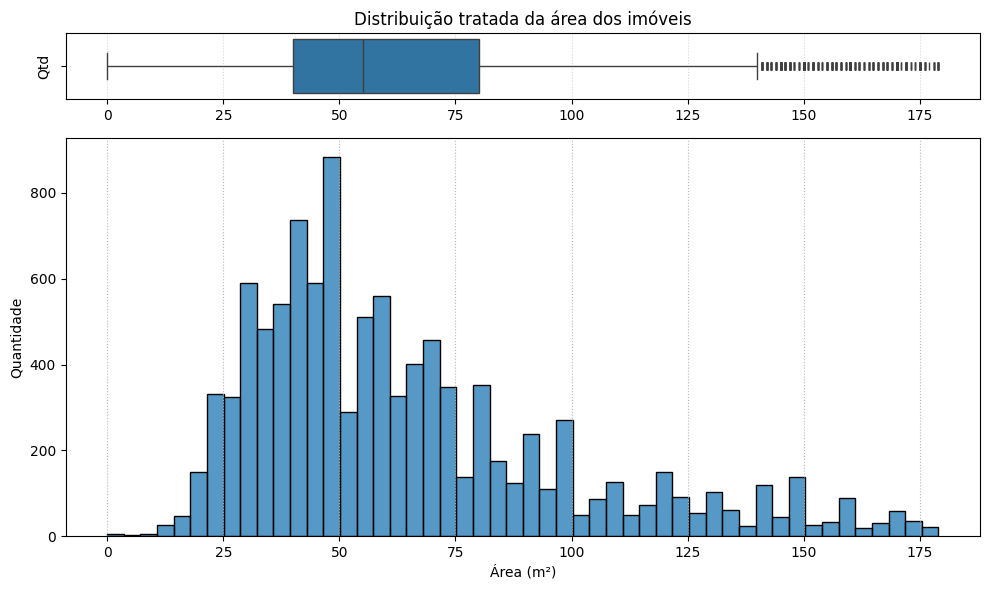

In [ ]:
# criando o gráfico para observar a distribuição da área
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[1,6]})

# boxplot das áreas
sns.boxplot(x=df_cleaned['area'], ax=axes[0], linewidth=1, flierprops={'marker':'|'})
axes[0].set_title('Distribuição tratada da área dos imóveis')
axes[0].grid(axis='x', linestyle=':', alpha=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Qtd')


# histograma com a distribuição das áreas
sns.histplot(df_cleaned['area'], ax=axes[1])
axes[1].set_xlabel('Área (m²)')
axes[1].set_ylabel('Quantidade')
axes[1].grid(axis='x', linestyle=':', alpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
# observando resultados satisfatórios atribuimos uma nova versão do df
df_v3 = df_cleaned

## Bedrooms/Garage


As variáveis `bedrroms` e `garage` são to tipo *int* e prepresentam o número de quartos e vagas de garagem váriamvariando de 0 até 5 e são valores fixos muito atrelados à metragem do imóvel, decidi não realizar nenhum tipo de tratamento deles.

In [ ]:
df_v3[['bedrooms', 'garage']].describe()

,bedrooms,garage
count,10507.000000,10507.000000
mean,1.802893,0.837918
std,0.785772,0.839090
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,2.000000,1.000000
max,6.000000,6.000000


## Type


A variável `type` é do tipo *string* e representa qual é o tipo do imóvel, podendo assumir quatro valores: Apartamento, Casa, Kitnet ou Casa em condomínio.

Para codificar essa variável, apliquei o procedimento *one-hot-encoding* utilizando o método [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), porém com uma rápida pesquisa encontrei que o próprio sckitlearn contém um método chamado [sklearn.preprocessing.OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) que atende melhor processos de machine learning, como o foco desse projeto é a análise de dados optei pelo uso da ferramenta do pandas.

Como são apenas 4 tipos de variáveis possíveis, o e método transcreverá facilmente os dados em colunas permitindo usa-los no modelo de aprendizagem.

In [ ]:
# criando uma variável para trabalhar com o type
tipo_ = df_v3['type'].value_counts()
tipo_ = tipo_.reset_index()
tipo_.columns = ['type', 'counts']
print(tipo_)

                 type  counts
0         Apartamento    6859
1                Casa    2070
2     Studio e kitnet    1381
3  Casa em condomínio     197


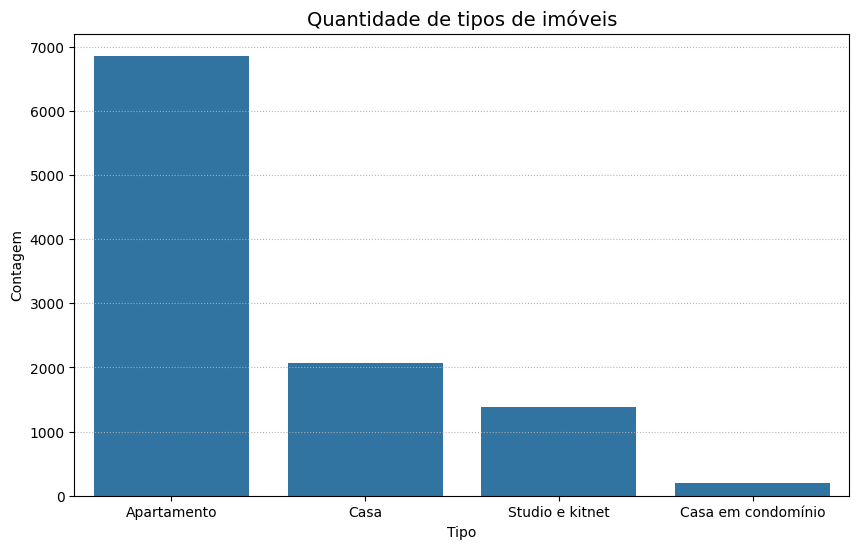

In [ ]:
# visualizando a distribuiçao dos tipos de imóveis
plt.figure(figsize=(10,6))
grafico = sns.barplot(data=tipo_, x='type', y='counts')
plt.grid(axis='y', linestyle=':', alpha=0.9)
plt.title('Quantidade de tipos de imóveis', fontsize=14)
plt.xlabel('Tipo')
plt.ylabel('Contagem')

plt.show()

In [ ]:
# aplicando o one-hot-encoding
df_type = df_v3[['type']]
df_type = pd.get_dummies(data=df_type)
df_type = df_type.replace({True:1, False:0})

In [ ]:
df_type.head()

,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet
0,0,0,0,1
1,0,0,0,1
2,1,0,0,0
3,0,0,1,0
4,0,0,0,1


In [ ]:
# anexando os dados novos e retirando a coluna 'type'
df_v3 = pd.concat([df_v3, df_type], axis=1)
df_v3.drop('type', axis=1, inplace=True)
df_v3

,area,bedrooms,garage,rent,total,district_encoded,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet
0,21,1,0,2400,2939,27,0,0,0,1
1,15,1,1,1030,1345,984,0,0,0,1
2,18,1,0,4000,4661,668,1,0,0,0
3,56,2,2,1750,1954,1097,0,0,1,0
4,19,1,0,4000,4654,26,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
11651,158,4,2,6500,8929,11,1,0,0,0
11652,94,2,1,4100,5778,709,1,0,0,0
11654,84,1,2,4500,5467,229,1,0,0,0
11655,76,1,0,9000,10200,271,1,0,0,0


## Rent/Total


As variáveis `rent` e `total` são do tipo *float* e representam respectivamento o valor bruto do aluguel e o valor líquido do aluguel, ou seja o valor do aluguel mais quaisquer taxas/impostos como IPTU(Imposto Predial e Territorial Urbano), taxas de condomínio, taxas de lixo entre outros.

Devido ao escopo do projeto, decidi trabalhar apenas com a variável `total`, pois esta reflete melhor o preço final do aluguel que estamos buscando. No entanto, deixarei registrada a relação entre as duas variáveis, pois essa relação pode, em muitos casos, ser um fator determinante na escolha de um imóvel. Embora o valor do aluguel possa ser atrativo, os custos adicionais podem aumentar significativamente o valor final.

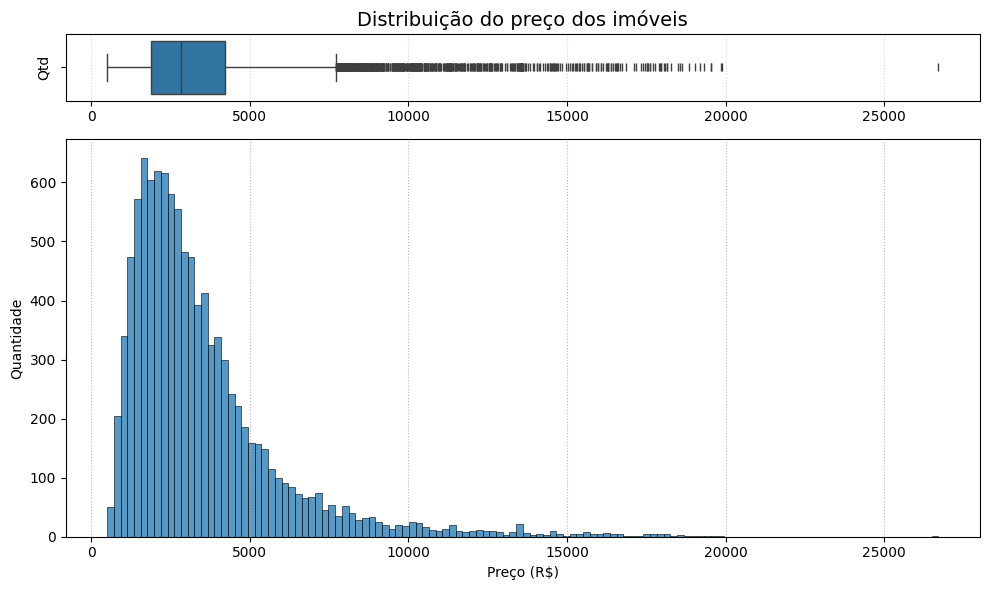

In [ ]:
# criando o gráfico para observar a distribuição do prço
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[1,6]})

# boxplot dos preços
sns.boxplot(x=df_v3['total'], ax=axes[0], linewidth=1, flierprops={'marker':'|'})
axes[0].set_title('Distribuição do preço dos imóveis', fontsize=14)
axes[0].grid(axis='x', linestyle=':', alpha=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Qtd')


# histograma com a distribuição dos preços
sns.histplot(df_v3['total'], ax=axes[1])
axes[1].set_xlabel('Preço (R$)')
axes[1].set_ylabel('Quantidade')
axes[1].grid(axis='x', linestyle=':', alpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
# utilizei o método de IQR para tratar os outliers.
df_cleaned2 = methot_iqr(df_v3,'total')
df_cleaned2['total'].describe().round(2)

count    9864.00
mean     3026.60
std      1532.85
min       509.00
25%      1843.00
50%      2712.00
75%      3916.25
max      7705.00
Name: total, dtype: float64

Aqui novamente após a aplicação do método IQR observamos uma diminuição de aproximadamente 6,11% no volume total dos dados, porém tal diminuição é justificada pelas características prodominanto no mercado imobiliário. Uma vez que imóveis de alto valor (com aluguel acima de R$ 8.000) são bem menos procurados na cidade, sendo esses exlusivos de poucos bairros que alocam esse tipo de imóvel.

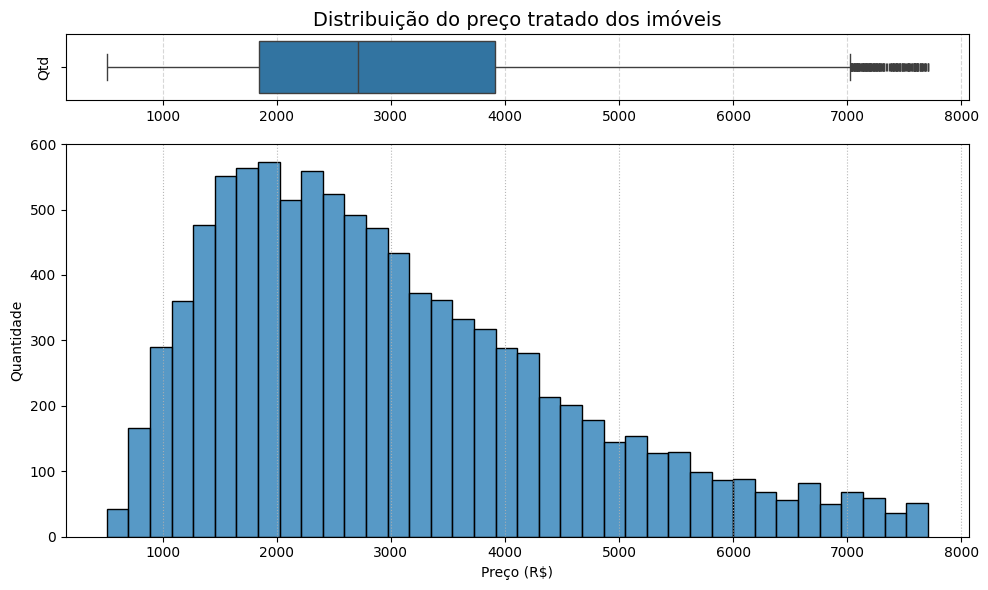

In [ ]:
# criando o gráfico para observar a distribuição da área
fig, axes = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[1,6]})

# boxplot das áreas
sns.boxplot(x=df_cleaned2['total'], ax=axes[0], linewidth=1, flierprops={'marker':'|'})
axes[0].set_title('Distribuição do preço tratado dos imóveis', fontsize=14)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Qtd')


# histograma com a distribuição das áreas
sns.histplot(df_cleaned2['total'], ax=axes[1])
axes[1].set_xlabel('Preço (R$)')
axes[1].set_ylabel('Quantidade')
axes[1].grid(axis='x', linestyle=':', alpha=0.9)

plt.tight_layout()
plt.show()

In [ ]:
df_cleaned2

,area,bedrooms,garage,rent,total,district_encoded,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet
0,21,1,0,2400,2939,27,0,0,0,1
1,15,1,1,1030,1345,984,0,0,0,1
2,18,1,0,4000,4661,668,1,0,0,0
3,56,2,2,1750,1954,1097,0,0,1,0
4,19,1,0,4000,4654,26,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
11640,78,2,1,2750,3686,229,1,0,0,0
11645,70,2,0,2230,3116,709,1,0,0,0
11652,94,2,1,4100,5778,709,1,0,0,0
11654,84,1,2,4500,5467,229,1,0,0,0


In [ ]:
# observando o resultado do dataframe está satisfatório, atualizamos o df
df_v4 = df_cleaned2

## Limpeza

In [ ]:
# removendo as colunas que não serão usadas no modelo
df_v4.drop('rent', axis=1, inplace=True)

Após o tratamento de todas as variáveis vamos observar como está o dataset final para que possamos avaliar seu uso nos modelos de aprendizagem.

In [ ]:
df_v4.describe().round(2)

,area,bedrooms,garage,total,district_encoded,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet
count,9864.00,9864.00,9864.00,9864.00,9864.00,9864.00,9864.00,9864.00,9864.00
mean,61.22,1.76,0.77,3026.60,572.11,0.64,0.21,0.02,0.14
std,31.82,0.76,0.80,1532.85,368.42,0.48,0.40,0.14,0.35
min,0.00,0.00,0.00,509.00,0.00,0.00,0.00,0.00,0.00
25%,39.00,1.00,0.00,1843.00,167.00,0.00,0.00,0.00,0.00
50%,53.00,2.00,1.00,2712.00,662.00,1.00,0.00,0.00,0.00
75%,75.00,2.00,1.00,3916.25,879.00,1.00,0.00,0.00,0.00
max,179.00,6.00,6.00,7705.00,1198.00,1.00,1.00,1.00,1.00


In [ ]:
df_v4.reset_index(drop=True, inplace=True)
df_v4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9864 entries, 0 to 9863
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   area                     9864 non-null   int64
 1   bedrooms                 9864 non-null   int64
 2   garage                   9864 non-null   int64
 3   total                    9864 non-null   int64
 4   district_encoded         9864 non-null   int64
 5   type_Apartamento         9864 non-null   int64
 6   type_Casa                9864 non-null   int64
 7   type_Casa em condomínio  9864 non-null   int64
 8   type_Studio e kitnet     9864 non-null   int64
dtypes: int64(9)
memory usage: 693.7 KB


Na matriz de correlação observamos que as variáveis que mais se correlacionam são a `area`, `badrooma` e `total`, assim são as que mais interferem no preço do aluguel; já as que menos se correlacionam são o `type` e o `district`, assim sendo as que menos influenciam. Porém mesmo havendo essa divisão de correlação todos eles serão usamos no modelo de aprendizagem.

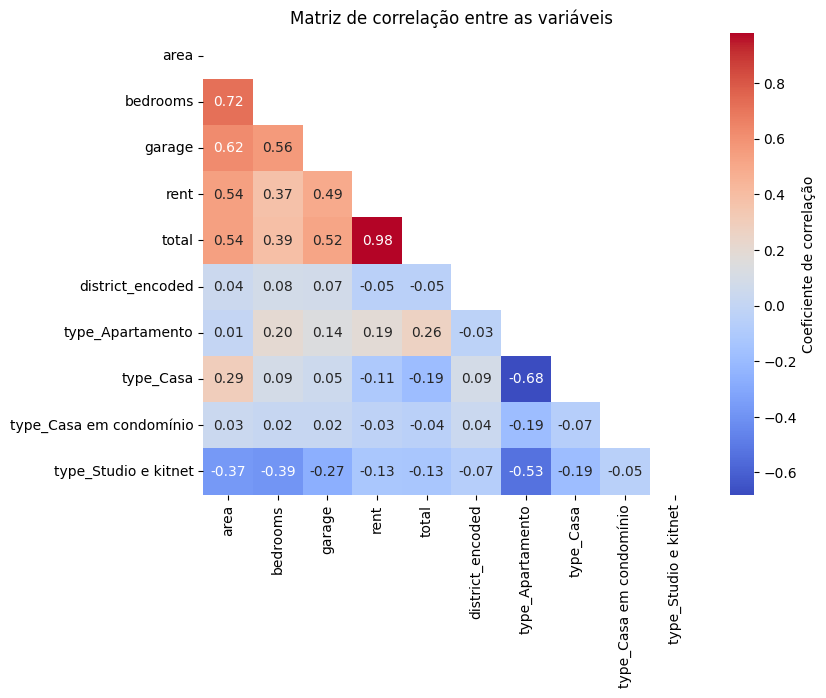

In [ ]:
# criando matriz de correlação
matriz = df_v3.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(matriz,annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(matriz),
            cbar_kws={'label':'Coeficiente de correlação'})
plt.title('Matriz de correlação entre as variáveis')
plt.show()

Vemos que o dataset está de acordo com os parâmetros de usabilidade: sem valores ausentes, dados padronizados, outliers tratados, variáveis codificadas e *features* definidas. Diante disso podemos proseguir para as próximas etapas.

# Treinamento do modelo

Seguindo os procedimentos para aplicação do modelo de aprendizagem, vamos começar com a etapa de divisão do nosso dados em  treino e testa, isolando nossa variável respota `total`. Para isso usaremos o método [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) que nos auxília na separação e garante que os dados estejam bem alocados.

In [ ]:
# criando os parâmetros do split
x_train, x_test, y_train, y_test = train_test_split(
    df_v4.drop(['total'], axis=1),# retirando a variável resposta
    df_v4['total'],
    test_size=0.30, # 30% separada para teste
    random_state=42
    )

In [ ]:
x_train

,area,bedrooms,garage,district_encoded,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet
1797,55,2,0,978,0,1,0,0
9787,81,3,1,559,1,0,0,0
4438,37,1,1,67,1,0,0,0
6213,69,1,0,33,1,0,0,0
8707,42,2,1,1106,1,0,0,0
...,...,...,...,...,...,...,...,...
5734,45,1,1,42,1,0,0,0
5191,47,2,1,56,1,0,0,0
5390,66,2,1,1037,1,0,0,0
860,31,1,1,156,0,0,0,1


## Treino de Randon Forest

Para a aboradagem desse projeto escolhi trabalhar com o modelo de [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), devido à algumas características desse modelo que são bem propícias aos dados que queremos trabalhar:


*   Lida bem com dados heterogêneos e não lineares, como visto em nossas variáveis de `area` e `total`, esse modelo consegue se adapatar bem com correlações de diversos níveis;
*   Resiliênte ao comportamento de [*overfitting*](https://aws.amazon.com/pt/what-is/overfitting/), que ocorre quando um modelo para de realizar previsões precisas com novos dados e começa a se ajustar excessivamente aos dados de treinamento, resultando em um desempenho pobre com novos dados. Esse problema ocorre com muito menos frequência na Random Forest;
*   Trabalha bem com variáveis categóricas, como temos em `type` e `district`, mesmo que já processadas esse modelo se adequa bem quando temos esse tipo de variável.


  *fonte: '[O que é Random Forest?](https://ebaconline.com.br/blog/random-forest-seo)', EBAC, fevereiro/24*


Funcionamento da Random Forest

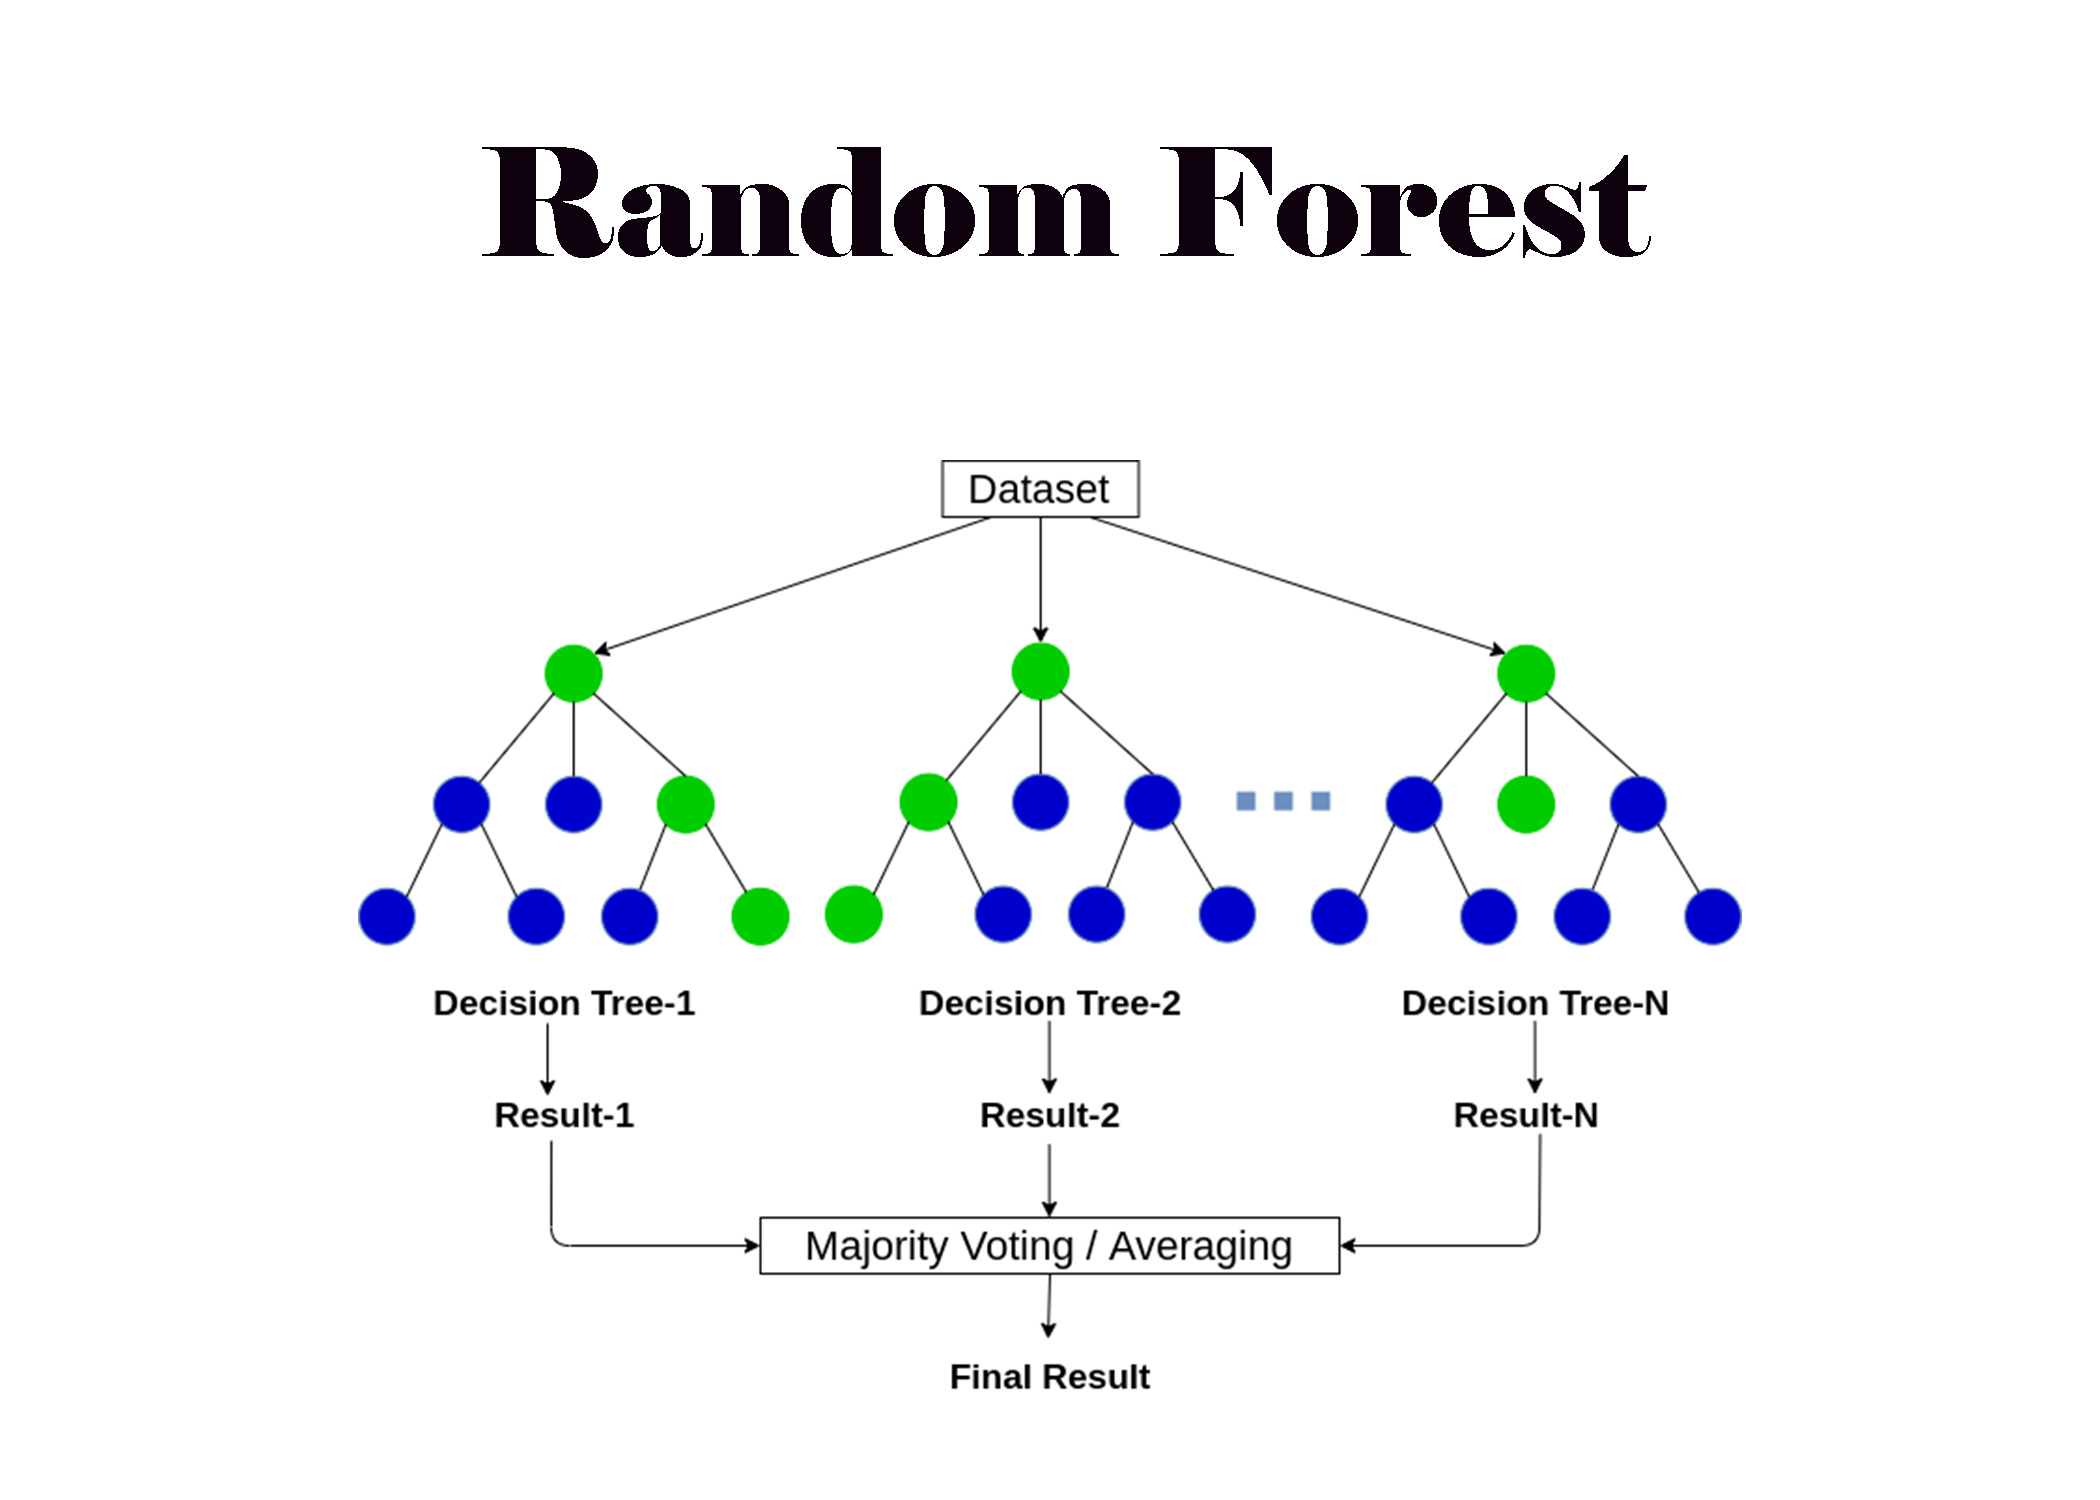






In [ ]:
# criado o modelo com os parâtros
modelo_rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=4,
    max_depth=20,
    random_state=42,
    n_jobs=-1)

# treinando o modelo
modelo_rf.fit(x_train, y_train)

# realizando as previsoes
y_pred = modelo_rf.predict(x_test)


In [ ]:
# Calculando o erro quadrático médio
mse_original = mean_squared_error(y_test, y_pred)
print('Erro Quadrático Médio:', mse_original)

# calculando a acurácia dos dados de treino
random_model_accuracy1 = round(modelo_rf.score(x_train, y_train)*100 ,2)
print(round(random_model_accuracy1, 2),'% de acurácia com os dados de treino')

# calculando a acurácia dos dados de teste
random_model_accuracy2 = round(modelo_rf.score(x_test, y_test)*100 ,2)
print(round(random_model_accuracy2, 2), '% de acurácia com os dados de teste')

Erro Quadrático Médio: 1062300.2543258364
74.89 % de acurácia com os dados de treino
55.96 % de acurácia com os dados de teste


## Otimização de Hiperparâmetros

Em todo modelo de aprendizagem temos, dois conceitos muito importantes que utilizamos durante sua construção: **parâmetros** (valores que o algoritimo ajusta durante o treinamento) e **hiperparâmetros** (valores ajustados antes do treinamento e que não são ajustados diretamente durante o treinamento).

Podemos então dizer que, ao iniciarmos um treino, os hiperparâmetros já foram definidos e eles moldarão os parâmetros que serão ajustados durante o processo de treinamento. Para que o algoritmo obtenha os parâmetros que apresentem os melhores resultados, ajustamos os hiperparâmetros para que eles influenciem positivamente o ajuste dos parâmetros.

Existem diversas maneiras de trabalhar com os hiperparâmetros, o método que foi usado nesse projeto é o chamado [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) que trata-se de um método do Scikit Learn onde basicamente passaremos diversos intervalos de diferentes parâmetros e ele ira criar uma base, onde usaremos em nosso modelo para treinar e assim escolher o que retorna o melhor resultado(*best_params_*), desse modo garantindo o melhor resultado possível dentro do universo passado aos hiperparâmetros.

*fonte: '[Otimização de Hiperâmetros](https://medium.com/otimiza%C3%A7%C3%A3o-de-hiperpar%C3%A2metros/par%C3%A2metros-e-hiperpar%C3%A2metros-67e27935d8b4)', Thiago Nunes, julho/20*

In [ ]:
# visualizando os parâmetros padrão do nosso modelo
modelo_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Com o ```modelo_rf.get_params()``` obtemos os parâmetros utilizados no modelo, alguns deles vamos utilizar no método de *RandomSearchCV* para aprimorar suas variáveis, vamos à um resumo:


*  `n_estimators`: número de árvores na floresta, mais árvores melhoram o desempenho até certo ponto;
*  `max_features`: número máximo de features consideradas para encontrar a melhor divisão, controla a diversidade das árvores;
* `max_depth`: profundidade máxima das árvores, controla o ajuste do modelo;
* `min_samples_split`: mínimo de amostras necessárias para dividir um nó;
* `min_samples_leaf`: mínimo de amostras em uma folha, garante um número de amostras em cada uma;
* `bootstrap`: método de amostragem com ou sem reposição, aumenta a diversidade entre as árvores.





In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int (x) for x in np.linspace(3,30,num =6)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,5,10]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap}
random_grid

{'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [3, 8, 13, 19, 24, 30, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 5, 10],
 'bootstrap': [True, False]}

In [ ]:
# modelagem dos hiperparametros

rf_random = RandomizedSearchCV(estimator = modelo_rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv=5,
                               verbose=3,
                               n_jobs=-1,
                               random_state=42)

rf_random.fit(x_train, y_train)

# no Google Colab essa etapa demora cerca de 18 minutos para ser processada

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=20,
                                                   min_samples_leaf=4,
                                                   n_estimators=300, n_jobs=-1,
                                                   random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 8, 13, 19, 24, 30,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 144, 188, 233,
                                                         277, 322, 366, 411,
                                                         455, 500]},
                   random_state=42, verbose=3)

In [ ]:
# conferindo os melhores parâmetros obtidos
rf_random.best_params_

{'n_estimators': 366,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 19,
 'bootstrap': True}

In [ ]:
#criando um modelo com os parametros obtidos
modelo_rf2 = RandomForestRegressor(n_estimators = 366,
                                   min_samples_split = 10,
                                   min_samples_leaf = 2,
                                   max_features = 1.0, # changed in version 1.1
                                   max_depth = 19,
                                   random_state=42,
                                   bootstrap=True,
                                   n_jobs=-1)
modelo_rf2.fit(x_train, y_train)

RandomForestRegressor(max_depth=19, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=366, n_jobs=-1, random_state=42)

In [ ]:
# calculando algumas métricas de avaliação

random_model_accuracy3 = round(modelo_rf2.score(x_train, y_train)*100 ,2)
print(round(random_model_accuracy3, 2),'% de acurácia nos dados de treino')

random_model_accuracy4 = round(modelo_rf2.score(x_test, y_test)*100 ,2)
print(round(random_model_accuracy4, 2),'% de acurácia nos dados de teste')

77.28 % de acurácia nos dados de treino
56.71 % de acurácia nos dados de teste


In [ ]:
# calculando a melhoria em comparação ao primeiro modelo
melhoria_train = random_model_accuracy3 -random_model_accuracy1
melhoria_test = random_model_accuracy4 - random_model_accuracy2
print(melhoria_train)
print(melhoria_test)

2.3900000000000006
0.75


Observamos que após a aplicação do método RandomizedSearchCV, houve melhorias nas previsões do nosso modelo de aprendizagem, com ganhos de **2,39%** nos dados de treino e **0,75%** nos dados de teste. Apesar de ser uma melhoria pequena, esse aumento já pode impactar significativamente nossos resultados.

Existem diversas outras maneiras de aprimorar nosso modelo, como o uso de outros métodos de otimização de hiperparâmetros, a criação de novas features, o pré-processamento de dados, a adição de novos dados, entre outras.

## Avaliação do Randon Forest


Com nosso modelo treinado vamos observar algumas métricas de avaliação para descobrir o comportamento dele.

* [**Erro Quadrático Medida (MSE)**](https://pt.wikipedia.org/wiki/Erro_quadr%C3%A1tico_m%C3%A9dio): mede o quão próximo as previsões estão dos valores reais, quanto menor melhor;
* [**Coeficiente de determinação (R²)**](https://pt.wikipedia.org/wiki/Coeficiente_de_determina%C3%A7%C3%A3o): mede a proporção da variabilidade na variável dependente, varia de 0 (não explica a variabilidade dos dados) até 1 (explica totaltamente a variabilidade dos dados);
* [**Erro Absoluto Médio (MAE)**](https://pt.wikipedia.org/wiki/Desvio_padr%C3%A3o): mensura o quão grande o erro médio do modelo nas previsões, quanto menor melhor;
* [**Raiz do Erro Quadrático**](https://pt.wikipedia.org/wiki/Desvio_padr%C3%A3o): raiz quadrada do MSE, está na mesma unidade de medida da variável reposta facilitando a interpretação, quanto menor melhor.

In [ ]:
# criando uma coluna onde aplicamos o modelo
df_v5 = df_v4
df_v5['preco_previsto'] = modelo_rf2.predict(df_v4.drop(['total'], axis=1))
df_v5['preco_previsto']

0       2154.407137
1       2098.081989
2       3583.209915
3       2979.396321
4       3433.190410
           ...     
9859    3364.989789
9860    2667.330585
9861    4881.105829
9862    5968.417038
9863    3793.487018
Name: preco_previsto, Length: 9864, dtype: float64

In [ ]:
# erro quadrático médio (MSE)
mse = mean_squared_error(df_v5['total'], df_v5['preco_previsto'])

# coeficiente de determinação (R²)
r2 = r2_score(df_v5['total'], df_v5['preco_previsto'])

# erro absoluto médio (MAE)
mae = mean_absolute_error(df_v5['total'], df_v5['preco_previsto'])

# raiz do erro quadrático médio (RMSE)
rmse = np.sqrt(mse)

In [ ]:
# criando um df com as métricas
metricas = {'MSE': mse,'R²': r2,'MAE': mae,'RMSE': rmse}
df_metricas = pd.DataFrame(metricas, index=[0])
df_metricas = df_metricas.T.reset_index()
df_metricas.columns = ['Métrica', 'Valor']
df_metricas

,Métrica,Valor
0,MSE,682657.931878
1,R²,0.709433
2,MAE,601.480408
3,RMSE,826.231161


**Conclusão sobre as métricas do modelo**

O MSE está bem alto mostrando que existem grandes erros nas previsões, porém ao análisar junto com o RMSE que está em R$ 826,23 vemos que a diferença entre o valor real e previsto está dentro de uma faixa razoável de precisão. Já o R² de 0,71 sugere que o modelo abrange 71% da variação prevista no modelo, deixando ainda 29% de variação que o modelo não explica. E por fim nosso MAE de 601,48 siginica que, em média, os valores previstos estão 601 unidades próximas dos valores reais.

De modo geral nosso modelo apresentou bom desempenho, prevendo com moderada exatidão os resultados esperados, porém ficou claro que há espaço para melhorias principalmento na reducão de erros maiores.

## Aplicação do modelo

Agora vamos aplicar o modelo em nosso banco de dados, para avaliarmos se os imóveis estão dentro do padrão do modelo:

Verificando se a diferença entre o `total` e o `preco_previsto` é aceitável ou não, para isso estípulei uma margem de 10%, assim quando o valor do imóvel for menor que o previsto ele irá identifica-lo.

In [ ]:
# criando as colunas com as classificações
df_v5.loc[:, 'diferenca'] = abs(df_v5['preco_previsto'] - df_v5['total'])
df_v5.loc[:, 'aceitavel'] = df_v5['diferenca'] <= (df_v5['total'] * 0.10)

Por fim vou criar uma coluna que irá dizer se o o preço do aluguel do imóvel está de acordo com o modelo de aprendizado, e assim dizer se o valor está menor (bom) ou maior(ruim)

In [ ]:
df_v5.loc[:, 'avaliacao']=['Acima do preço' if previsto > real
                           else 'Abaixo do preço' for previsto, real in zip(
                               df_v5['preco_previsto'], df_v5['total'])]

Com os imóveis avaliados, vemos as porcentagens de imóveis que estão com o valor acima ou abaixo segundo nosso modelo de previsão.

In [ ]:
porcentagem_aceitavel = (df_v5['aceitavel'].sum() / df_v5.shape[0]) * 100
porcentagem_nao_aceitavel = 100 - porcentagem_aceitavel

print('Porcentagem de preços abaixo:', round(porcentagem_aceitavel,2), '%')
print('Porcentagem de preços acima:', round(porcentagem_nao_aceitavel,2), '%')

Porcentagem de preços abaixo: 31.98 %
Porcentagem de preços acima: 68.02 %


In [ ]:
df_v5.head()

,area,bedrooms,garage,total,district_encoded,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet,preco_previsto,diferenca,aceitavel,avaliacao
0,21,1,0,2939,27,0,0,0,1,2154.407137,784.592863,False,Abaixo do preço
1,15,1,1,1345,984,0,0,0,1,2098.081989,753.081989,False,Acima do preço
2,18,1,0,4661,668,1,0,0,0,3583.209915,1077.790085,False,Abaixo do preço
3,56,2,2,1954,1097,0,0,1,0,2979.396321,1025.396321,False,Acima do preço
4,19,1,0,4654,26,0,0,0,1,3433.190410,1220.809590,False,Abaixo do preço


# Conclusão

Com nosso modelo já treinado, otimizado, avaliado e aplicado vamos explorar seus resultados quando retornamos ao nosso problema inicial de identificar se o preço de um imóvel está dentro do padrão, e quais são as variáveis que mais influênciam nisso.

## Importancia das Features


Dentro do próprio modelo da Random Forest encontramos um método próprio ([.feature_importances_ ](https://medium.com/lets-data/desvendando-a-import%C3%A2ncia-das-features-em-data-science-102b1d2def2e)) que qualifica cada *feature* por sua importância dentro da construção do modelo. Assim ao interpretarmos elas vemos quais as *features* mais fornecem divisões ao modelo, e assim podemos dar um atenção especial à elas pois oferecem mais informação ao modelo.

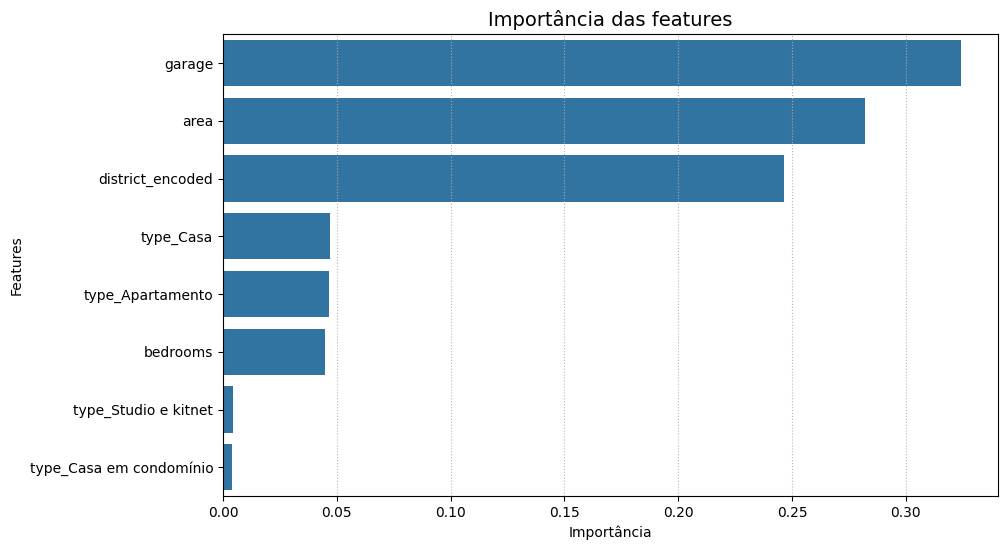

In [ ]:
# extraindo e salvando os valorers das feature_importances_
importances = modelo_rf2.feature_importances_
nomes_features = x_train.columns
indices = np.argsort(importances)[::-1]

# criando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[nomes_features[i] for i in indices], orient='h')
plt.title('Importância das features', fontsize=14)
plt.xlabel('Importância')
plt.ylabel('Features')
plt.grid(axis='x', linestyle=':', alpha=0.9)
plt.show()

Observamos então que as variáveis que mais determinam se o preço do imóvel estará dentro do padrão são `garage` seguido de `area` e `district`. Ou seja as variáveis que mais atuam no preço final são o número de vagas na garagem, o tamanho do imóvel e o bairro, assim podemos focar em trabalhar mais com elas para extrair novos *insights*, e estudar como melhorar o modelo à partir delas, como por exemplo: 'com o aumento do número de automóveis, casas com mais de uma vaga podem se tornar mais atrativas' ou 'o tamanho de casa em determinada região pode ser mais procurado' entre diversos outros.

## Residual Plots


Com o [*Residual Plot*](https://support.minitab.com/pt-br/minitab/help-and-how-to/statistical-modeling/predictive-analytics/how-to/random-forests-regression/interpret-the-results/boxplot-of-residuals/) (gráfico de erros) podemos avaliar a extatidão geral do modelo, com ele podemos ver o quão próximo de zero estão nosso erros, nele observamos de maneira mais prática se estamos errando com muita ou pouca diferença.

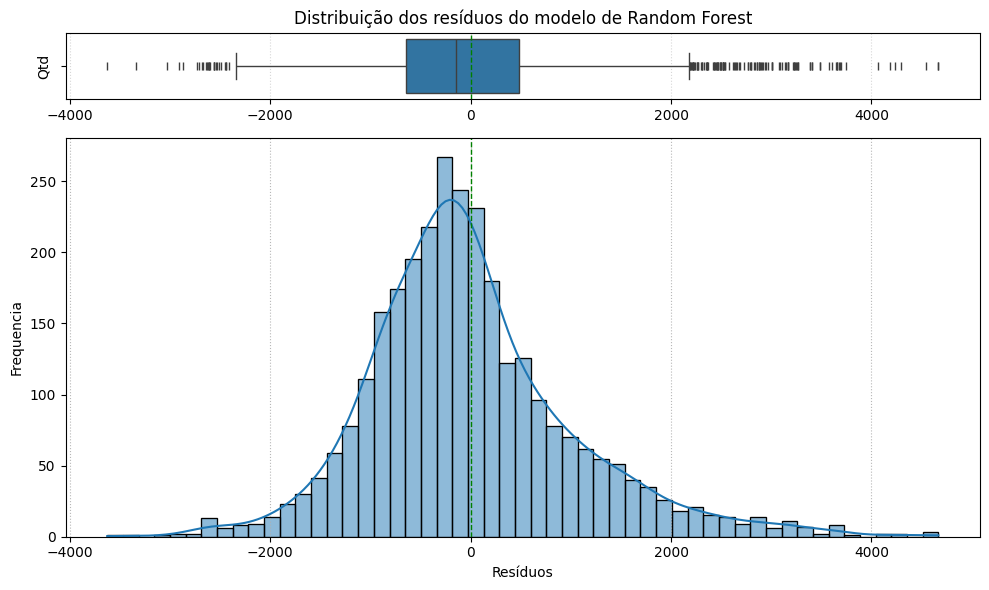

In [ ]:
# definindo os tipos das variáveis a serem usadas
y_test_2 = pd.Series(y_test)
y_pred_2 = np.array(y_pred)

# definindo a diferença entre acerto e erro
residuos = y_test_2 - y_pred_2

# criando o gráfico para observar a distribuição dos erros
fig, axes = plt.subplots(2, 1, figsize=(10, 6),
                         gridspec_kw={'height_ratios':[1,6]})

# boxplot dos erros
sns.boxplot(x=residuos, ax=axes[0], linewidth=1, flierprops={'marker':'|'})
axes[0].set_title('Distribuição dos resíduos do modelo de Random Forest')
axes[0].grid(axis='x', linestyle=':', alpha=0.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Qtd')
axes[0].axvline(x=0, color='green', linestyle="--", linewidth=1)


# histograma com a distribuição dos erros
sns.histplot(residuos, ax=axes[1], kde=True)
axes[1].set_xlabel('Resíduos')
axes[1].set_ylabel('Frequencia')
axes[1].grid(axis='x', linestyle=':', alpha=0.9)
axes[1].axvline(x=0, color='green', linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

Observamos que os grande parte dos erros se encontram próximos à 0, havendo alguns outlier tanto positivos quato negativos isso mostra que nosso modelo apresenta erros toleráveis uma vez que estão, em sua maioria, próximos de 0.

## Correlação

Por fim iremos visualizar a correlação entre o preço real do imóvel contra o preço que nosso modelo de regressão de árvore aleatória estipulou para o imóvel.

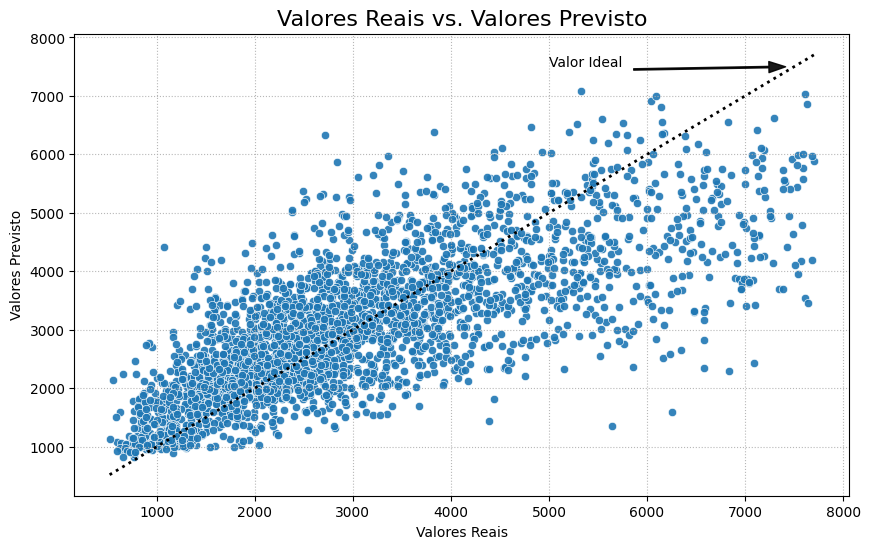

In [ ]:
# gráfico de distribuição
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.9)

# linha do valor ideal
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         ':', lw=2, color='black')
plt.annotate('Valor Ideal',
             xy=(7500,7500),
             xytext=(5000,7500),
             arrowprops=dict(facecolor='black', shrink=0.05,alpha =0.9,
                             width=1, headwidth=8))
# legendas
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previsto')
plt.title('Valores Reais vs. Valores Previsto', fontsize=16)
plt.grid(axis='both', linestyle=':', alpha=0.9)

plt.show()

Com esse gráfico podemos observar quanto maior o valor real do imóvel mais ele tende a ser diferente da nossa previsão, isso pode ser causado por diversos fatores. De modo geral os valores tem um correlação positiva, acompanhando a linha de valor ideal (onde ambos valores são iguais).


## Resultados

Após todo o processo de análise exploratória dos dados, pré-processamento, treinamento do modelo, avaliação do modelo e aplicação, chegamos à conclusão de que nosso modelo de regressão utilizando a Random Forest apresenta bons resultados na previsão do preço de aluguel de imóveis. Levando em conta diversos fatores, ele conseguiu explicar uma parte significativa das amostras.

Como melhorias futuras, podemos explorar outros modelos de aprendizagem, novos tratamentos de dados, incorporação de dados adicionais e aprimorar o detalhamento dos resultados. Durante o desenvolvimento deste projeto, tive contato com diversas boas ideias, como a junção de dados socioeconômicos do IBGE, mapeamento geográfico dos bairros e sua caracterização, avaliação de cada tipo de imóvel separadamente, modelo de regressão dos valores e modelo de clusterização de tipos de imóveis, entre outros. Embora essas ideias tenham ficado um pouco fora do escopo atual, pretendo retomar esse projeto no futuro, utilizando novos conhecimentos para sempre melhorar seu desempenho.

Sem dúvida, este projeto demonstrou o grande potencial dos modelos de aprendizagem no campo do mercado imobiliário, mostrando que podemos agregar muito em diversos aspectos desse ramo, que apresenta uma quantidade e qualidade incrível de dados.



---




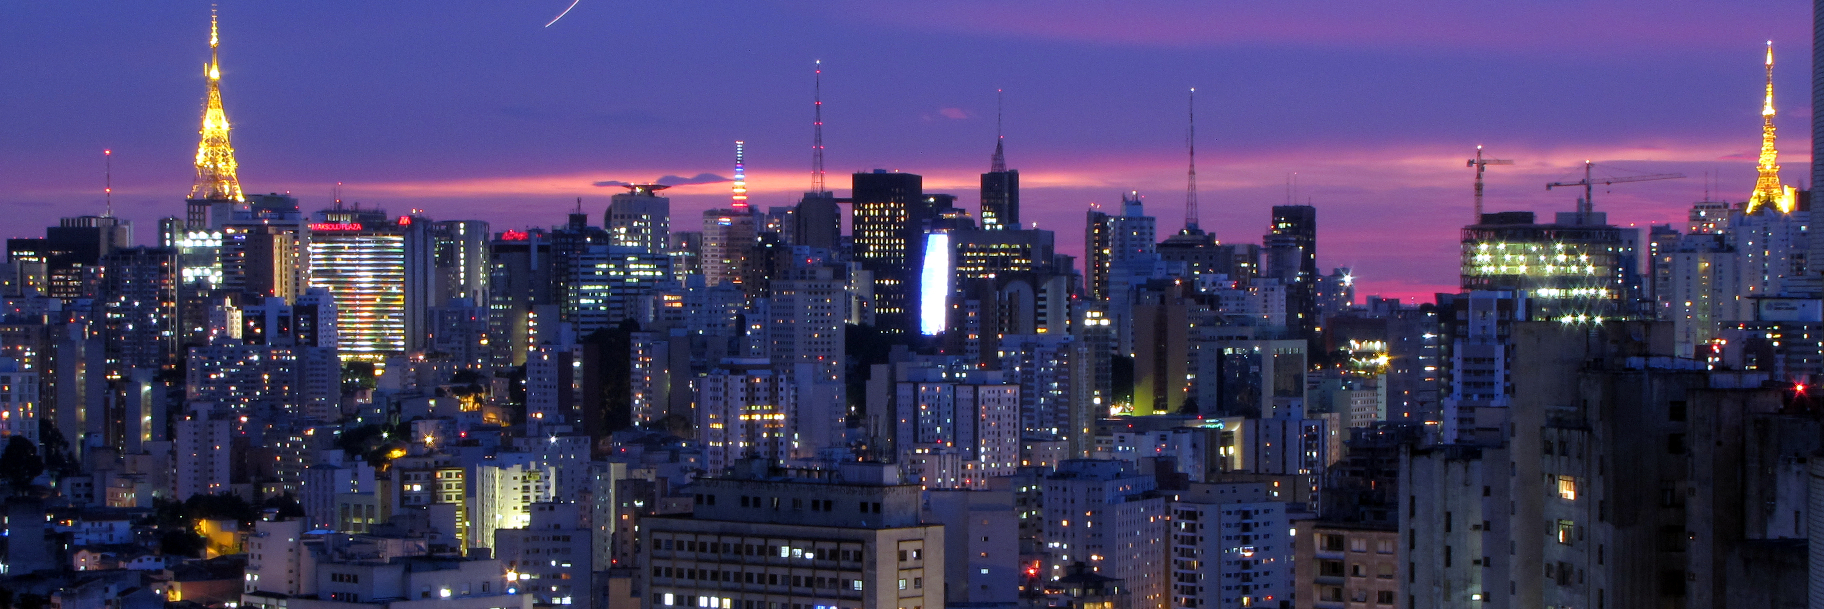



*fonte:[São Paulo city, Bela Vista](https://en.wikipedia.org/wiki/File:S%C3%A3o_Paulo_city_%28Bela_Vista%29_%28banner_esVoy%29.jpg), Júlio Boaro, 2012*